## Importing the relevant packages

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D

## Loading the data from google drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
list_ds = tf.data.Dataset.list_files('/content/drive/MyDrive/tablenet_data/Marmot_data/*.xml')

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Table Mask', 'Column Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

## Loading the pre-trained DenseNet121 models


In [ ]:
model_vgg19=tf.keras.models.load_model('/content/drive/MyDrive/model_vgg19')
model_densenet121=tf.keras.models.load_model('/content/drive/MyDrive/model_densenet121')
model_resnet50_1=tf.keras.models.load_model('/content/drive/MyDrive/model_resnet50_1')
vgg_19=np.load('/content/drive/MyDrive/model_vgg19_history.npy',allow_pickle=True).item()
resnet_50=np.load('/content/drive/MyDrive/model_resnet50_1_history.npy',allow_pickle=True).item()
densenet_121=np.load('/content/drive/MyDrive/model_densenet121_history.npy',allow_pickle=True).item()

## Installing the crfasrrn_keras package for using CRF layer

In [ ]:
!git clone https://github.com/sadeepj/crfasrnn_keras.git

In [ ]:
%cd /content/crfasrnn_keras
!pip install -r /content/crfasrnn_keras/requirements_gpu.txt  # If you have a GPU device, use requirements_gpu.txt instead

In [ ]:
%cd /content/crfasrnn_keras/src/cpp
!make

In [ ]:
%cd /content/crfasrnn_keras/src
from crfrnn_layer import CrfRnnLayer
# from tensorflow.keras.layers import Layer, InputSpec

## Adding CRF layer to base DenseNet model and freezing the parameters of DenseNet model


In [ ]:
def add_crf_layer(original_model):
    original_model.trainable = False

    crf_layer = CrfRnnLayer(image_dims=(256, 256),
                            num_classes=3,
                            theta_alpha=3.,
                            theta_beta=160.,
                            theta_gamma=3.,
                            num_iterations=100,
                            name='crfrnn')([original_model.outputs[0], original_model.inputs[0]])

    new_crf_model = tf.keras.Model(inputs = original_model.input, outputs = crf_layer)
    return(new_crf_model)

In [ ]:
crf_model = add_crf_layer(model_densenet121)

In [ ]:
crf_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGG-19 (Functional)            [(None, 64, 64, 256  4322880     ['input[0][0]']                  
                                ),                                                                
                                 (None, 32, 32, 512                                               
                                ),                                                                
                                 (None, 16, 16, 102                                         

## Training the new CRF layer


In [ ]:
losses = {
	"crfrnn": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
}

lossWeights = {"crfrnn": 1.0}

crf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.01,epsilon=1e-08),
              loss=losses,
              metrics=['accuracy'],
              loss_weights=lossWeights)

In [ ]:
img_height, img_width = 256, 256

def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image


def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_bmp(img)[:,:,:3]
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def decode_mask_img(img):
  # convert the compressed string to a 2D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=1)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])


def process_path(file_path):
  file_path = tf.strings.regex_replace(file_path, '.xml', '.bmp')

  mask_file_path = tf.strings.regex_replace(file_path, '.bmp', '.jpeg')

  table_mask_file_path = tf.strings.regex_replace(mask_file_path, 'Marmot_data', 'table_mask')
  # column_mask_file_path = tf.strings.regex_replace(mask_file_path, 'Marmot_data', 'column_mask')

  img = normalize(decode_img(tf.io.read_file(file_path)))
  table_mask = normalize(decode_mask_img(tf.io.read_file(table_mask_file_path)))
  # column_mask = normalize(decode_mask_img(tf.io.read_file(column_mask_file_path)))

  return img, {"crfrnn" : table_mask}

In [ ]:
# dataset = list_ds.map(process_path)

DATASET_SIZE = len(list(list_ds))
train_size = int(0.9 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

train = list_ds.take(train_size)
test = list_ds.skip(train_size)

TRAIN_LENGTH = len(list(train))
BATCH_SIZE = 1
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = train.shuffle(BUFFER_SIZE)

train = train.map(process_path,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

test = test.map(process_path)

train_dataset = train.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
EPOCHS = 1
VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size//BATCH_SIZE//VAL_SUBSPLITS


crf_model_history = crf_model.fit(train_dataset, epochs=EPOCHS,
                          validation_data=test_dataset)

444/444 [==============================] - 3669s 8s/step - loss: 0.0569 - accuracy: 0.9667 - val_loss: 0.0797 - val_accuracy: 0.9651


In [ ]:
np.save('/content/drive/MyDrive/crf_model0_history.npy',crf_model_history.history)
crf_model.save('/content/drive/MyDrive/crf_model0')

In [ ]:
crf_model_history=np.load('/content/drive/MyDrive/crf_model1_history.npy',allow_pickle=True).item()
crf_model=tf.keras.models.load_model('/content/drive/MyDrive/crf_model1')

## Results for CRF layer

In [ ]:
crf_model_history

{'loss': [0.056888263672590256],
 'accuracy': [0.967319667339325],
 'val_loss': [0.08419203758239746],
 'val_accuracy': [0.9613494873046875]}

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  if(len(display_list)==3):
    title = ['Input Image', 'Table Mask', 'Column Mask']
  else:
    title=['Input Image', 'Table Mask', 'Column Mask','Actual Table Mask','Actual Column Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
def create_mask(pred_mask1, pred_mask2):
  pred_mask1 = tf.argmax(pred_mask1, axis=-1)
  pred_mask1 = pred_mask1[..., tf.newaxis]


  pred_mask2 = tf.argmax(pred_mask2, axis=-1)
  pred_mask2 = pred_mask2[..., tf.newaxis]
  return pred_mask1[0], pred_mask2[0]

##############################################################################################################################
Results for DENSENET121
1/1 [==============================] - 2s 2s/step
IoU for table mask output is 0.9381439968991246


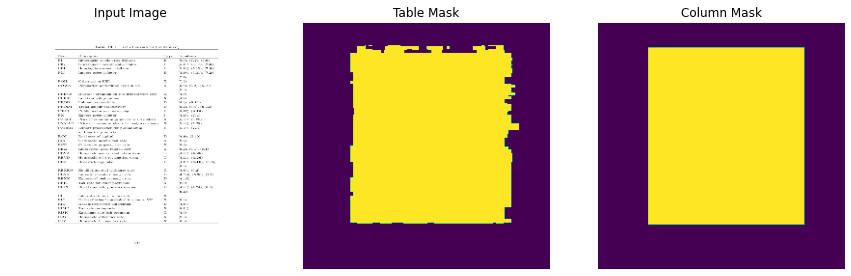

##############################################################################################################################
Results for CRF MODEL
1/1 [==============================] - 6s 6s/step
IoU for table mask output is 0.9477033400090445


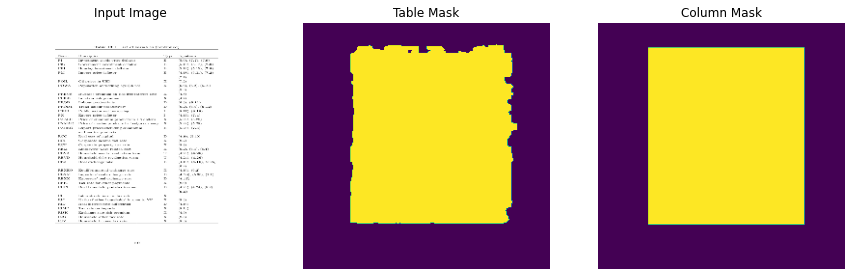

##############################################################################################################################
Results for VGG19
1/1 [==============================] - 1s 1s/step
IoU for table mask output is 0.8555541632729778


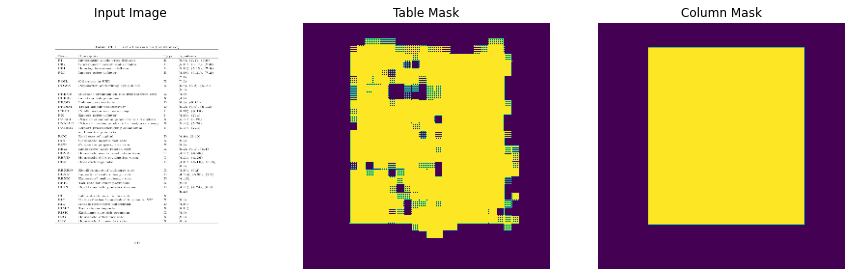

##############################################################################################################################
Results for RESNET50
1/1 [==============================] - 2s 2s/step
(1, 256, 256, 3)
IoU for table mask output is 0.31057419544165116


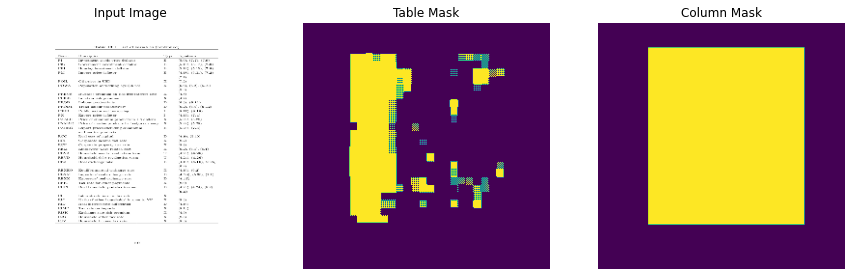

##############################################################################################################################


In [ ]:
for image, mask in train_dataset.take(1):
  sample_image, sample_mask1 = image, mask['crfrnn']

def iou_loss(image1,image2,i):
  # IoU calculation
  intersection = np.logical_and(image1, image2)
  union = np.logical_or(image1, image2)
  iou_score = np.sum(intersection) / np.sum(union)
  if i==1:
    print('IoU for table mask output is %s' % iou_score)
  elif i==2:
    print('IoU for column mask output is %s' % iou_score)


def show_predictions_densenet121(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      print(image.shape)
      pred_mask1, pred_mask2 = model_densenet121.predict(image, verbose=1)
      scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
      print("Table loss: "+str(scce(mask['table_output'][0],pred_mask1[0]).numpy()))
      print("Column loss: "+str(scce(mask['column_output'][0],pred_mask2[0]).numpy()))
      table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
      display([image[0], table_mask, column_mask,mask['table_output'][0], mask['column_output'][0]])
  else:
    pred_mask1, pred_mask2 = model_densenet121.predict(sample_image, verbose=1)
    table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
    iou_loss(sample_mask1[0],table_mask,1)
    # iou_loss(sample_mask2[0],column_mask,2)
    display([sample_image[0], table_mask, sample_mask1[0]])
    print("##############################################################################################################################")
    print("Results for CRF MODEL")
    pred_mask01 = crf_model.predict(sample_image, verbose=1)
    table_mask1, column_mask = create_mask(pred_mask01, pred_mask2)
    iou_loss(sample_mask1[0],table_mask1,1)
    # iou_loss(sample_mask2[0],column_mask,2)
    display([sample_image[0], table_mask1, sample_mask1[0]])

def show_predictions_vgg19(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      print(image.shape)
      pred_mask1, pred_mask2 = model_vgg19.predict(image, verbose=1)
      scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
      print("Table loss: "+str(scce(mask['table_output'][0],pred_mask1[0]).numpy()))
      print("Column loss: "+str(scce(mask['column_output'][0],pred_mask2[0]).numpy()))
      table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
      display([image[0], table_mask, column_mask,mask['table_output'][0], mask['column_output'][0]])
  else:
    pred_mask1, pred_mask2 = model_vgg19.predict(sample_image, verbose=1)
    table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
    iou_loss(sample_mask1[0],table_mask,1)
    # iou_loss(sample_mask2[0],column_mask,2)
    display([sample_image[0], table_mask, sample_mask1[0]])

def show_predictions_resnet50_1(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      print(image.shape)
      pred_mask1, pred_mask2 = model_resnet50_1.predict(image, verbose=1)
      scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
      print("Table loss: "+str(scce(mask['table_output'][0],pred_mask1[0]).numpy()))
      print("Column loss: "+str(scce(mask['column_output'][0],pred_mask2[0]).numpy()))
      table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
      display([image[0], table_mask, column_mask])
  else:
    pred_mask1, pred_mask2 = model_resnet50_1.predict(sample_image, verbose=1)
    print(pred_mask1.shape)
    table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
    iou_loss(sample_mask1[0],table_mask,1)
    # iou_loss(sample_mask2[0],column_mask,2)
    display([sample_image[0], table_mask, sample_mask1[0]])
    

def show_predictions_crfmodel(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      print(image.shape)
      pred_mask1 = crf_model.predict(image, verbose=1)
      scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
      print("Table loss: "+str(scce(mask['crfrnn'][0],pred_mask1[0]).numpy()))
      print("Column loss: "+str(scce(mask['column_output'][0],pred_mask2[0]).numpy()))
      table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
      display([image[0], table_mask, column_mask])
  else:
    pred_mask1 = crf_model.predict(sample_image, verbose=1)
    
    # pred_mask1 = pred_mask1.reshape(256,256,3)
    table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
    iou_loss(sample_mask1[0],table_mask,1)
    display([sample_image[0], tablemask, sample_mask1[0]])

print("##############################################################################################################################")
print("Results for DENSENET121")
show_predictions_densenet121()
print("##############################################################################################################################")
print("Results for VGG19")
show_predictions_vgg19()
print("##############################################################################################################################")
print("Results for RESNET50")
show_predictions_resnet50_1()
print("##############################################################################################################################")